# Лабораторная работа 2: «Разработка сверточной нейронной сети с использованием PyTorch»

## Цели работы

**Цель** —разработать и обучить сверточную нейронную сеть для задачи классификации изображений на наборе данных [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) с использованием  PyTorch.

## Требования к результатам выполнения работы

1. Требования к структуре и содержимому Jupyter Notebook:
    - Загрузить и проверить данные (необходимо обеспечить демонстрацию избранных изображений и меток классов для подтверждения корректности загрузки и совпадения размерностей).
    - Реализовать архитектуру нейронной сеть с использованием фреймворка PyTorch.
    - Настроить гиперпараметры обучения (например, архитектуры, скорости обучения и размера пачки (batch size)).
    - Вывести ошибку классификации и точность на тренировочном наборе данных по окончании каждой эпохи.
    - Вывести ошибку классификации на тестовом наборе данных и построить график ошибки обучения после обучения.

2. Выбор архитектуры:
    - Необходимо использовать ***сверточные*** архитектуры нейронных сетей
    - Разрешается использовать как готовые архитектуры (например, VGG, ResNet и тд), так и архитектуры разработанные студентом самостоятельно.
    - Реализация должна быть выполнена с нуля в PyTorch, без использования готовых модулей (например, import Resnet недопустимо).

In [28]:
!export DATASET_ARCHIVE="cifar-10-python.tar.gz" &&\
wget -O "$DATASET_ARCHIVE" "https://www.cs.toronto.edu/~kriz/$DATASET_ARCHIVE" &&\
tar -xvf "$DATASET_ARCHIVE" --overwrite

--2024-10-28 18:43:45--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162,60M  20,2MB/s    in 9,1s    

2024-10-28 18:43:54 (17,9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [29]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

%matplotlib inline

In [30]:
def load_cifar_10_data(dataset_path):
    def unpickle(file):
        with open(file, 'rb') as fo:
            dictionary = pickle.load(fo, encoding='bytes')
        return dictionary

    def transform_images(images):
        images = images.reshape((-1, 3, 32, 32))
        return images / 255.

    train_images = np.zeros((0, 3*32*32,), dtype=np.uint8)
    train_labels = np.zeros((0,), dtype=np.uint8)

    for i in range(5):
        data = unpickle(os.path.join(
            dataset_path,
            f"data_batch_{i + 1}",
        ))
        train_images = np.append(
            train_images,
            data[b'data'],
            axis=0,
        )
        train_labels = np.append(
            train_labels,
            data[b'labels'],
            axis=0,
        )
    train_images = transform_images(train_images)

    data = unpickle(os.path.join(
        dataset_path,
        "test_batch",
    ))
    test_images = np.array(data[b'data'], dtype=np.uint8)
    test_images = transform_images(test_images)
    test_labels = np.array(data[b'labels'], dtype=np.uint8)

    label_names = unpickle(os.path.join(
        dataset_path,
        "batches.meta",
    ))[b'label_names']
    label_names = list(map(lambda name: name.decode('UTF-8'), label_names))

    return train_images, train_labels, test_images, test_labels, label_names

train_images, train_labels, test_images, test_labels, label_names = load_cifar_10_data("cifar-10-batches-py")
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.2, random_state=42, stratify=test_labels)

print(f"Тренировочные данные:\n{train_images.shape=}; {train_labels.shape=}")
print(f"Валидационные данные:\n{val_images.shape=}; {val_labels.shape=}")
print(f"Тестовые данные:\n{test_images.shape=}; {test_labels.shape=}")

Тренировочные данные:
train_images.shape=(50000, 3, 32, 32); train_labels.shape=(50000,)
Валидационные данные:
val_images.shape=(2000, 3, 32, 32); val_labels.shape=(2000,)
Тестовые данные:
test_images.shape=(8000, 3, 32, 32); test_labels.shape=(8000,)


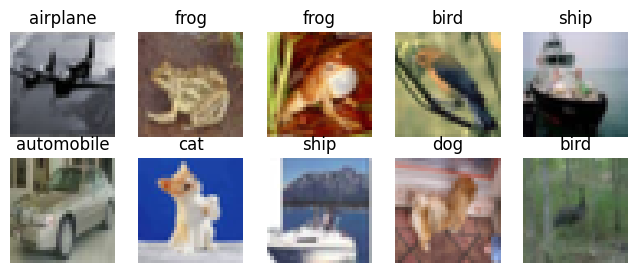

In [31]:
def plot_10_samples(samples, labels, label_names=None):
    fig = plt.figure(figsize=(8, 3))

    for idx, (sample, label) in enumerate(zip(samples, labels)):
        sample = sample.transpose(1, 2, 0)
        name = label if label_names is None else label_names[label]

        plt.subplot(2, 5, idx + 1)
        plt.imshow(sample)
        plt.axis('off')
        plt.title(name)

random_indexes = np.random.randint(0, train_images.shape[0], 10)
plot_10_samples(train_images[random_indexes], train_labels[random_indexes], label_names)

In [32]:
class CifarDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def images(self):
        return self.images

    def labels(self):
        return self.labels

In [33]:
def train_epoch(model, optimizer, criterion, data_loader, device, description="Batches processing"):
    total_batches = len(data_loader)

    model.train()
    for (images, labels) in tqdm(
        data_loader,
        total=total_batches,
        desc=description
    ):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test(model, criterion, data_loader, device, description="Calculating loss & error"):
    model.eval()

    total_batches = len(data_loader)
    total = len(data_loader.dataset)

    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for (images, labels) in tqdm(
            data_loader,
            total=total_batches,
            desc=description
        ):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss += criterion(outputs, labels).item()

            _, predicts = torch.max(outputs, dim=1)
            accuracy += (predicts == labels).sum().item()

    return (loss / total_batches), (accuracy / total)

def train(model, optimizer, criterion, train_data_loader, val_data_loader, epochs, device, best_weigths_path="best_weights"):
    best_loss = None

    train_losses, val_losses = [], []
    train_errors, val_errors = [], []

    for epoch in range(epochs):
        train_epoch(model, optimizer, criterion, train_data_loader, device, description=f"Epoch {epoch + 1} - batches processing")

        train_loss, train_accuracy = test(model, criterion, train_data_loader, device, "Calculating train loss & accuracy")
        val_loss, val_accuracy = test(model, criterion, val_data_loader, device, "Calculating val loss & accuracy")

        train_losses.append(train_loss)
        train_errors.append(1 - train_accuracy)

        val_losses.append(val_loss)
        val_errors.append(1 - val_accuracy)

        if best_loss is None or val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_weigths_path)

        print(f"train_loss={train_loss:.4f}, train_error={1 - train_accuracy:.4f}")
        print(f"val_loss={val_loss:.4f}, val_error={1 - val_accuracy:.4f}", end='\n'*2)

    return train_losses, train_errors, val_losses, val_errors

In [34]:
class MNConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(MNConv, self).__init__()
        padding = (kernel_size - stride) // 2

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class MNBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion_factor=6):
        super(MNBottleneck, self).__init__()

        self.use_residual = stride == 1 and in_channels == out_channels

        hidden_channels = in_channels * expansion_factor
        self.conv = nn.Sequential(
            MNConv(in_channels, hidden_channels, 1, 1),
            MNConv(hidden_channels, hidden_channels, 3, stride),
            nn.Conv2d(hidden_channels, out_channels, 1, 1, 0),
        )

    def forward(self, x):
        if self.use_residual:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MNBasedNeuralNetwork(nn.Module):
    def __init__(self, num_classes=10, config=None):
        super(MNBasedNeuralNetwork, self).__init__()

        if config is None:
            config = [
                # t,   c, n, s
                [ 1,  16, 1, 1],
                [ 6,  24, 2, 2],
                [ 6,  32, 3, 1],
                [ 6,  64, 4, 1],
                [ 6,  96, 3, 1],
                [ 6, 160, 3, 2],
                [ 6, 320, 1, 1],
            ]
        self.last_channels = 320

        last_channels = 32
        features = [nn.Conv2d(3, last_channels, 3, 1, 1)]

        for t, c, n, s in config:
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(MNBottleneck(last_channels, c, stride, t))
                last_channels = c

        features.append(nn.Conv2d(last_channels, self.last_channels, 1, 1, 0))

        self.features = nn.Sequential(*features)

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channels, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        return self.classifier(x)


In [35]:
learning_rate = 1e-4
batch_size = 32
epochs = 50

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device - \"{device}\"")

model = MNBasedNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_data_loader = DataLoader(CifarDataset(train_images, train_labels), batch_size, shuffle=True)
val_data_loader = DataLoader(CifarDataset(val_images, val_labels), batch_size)

train_losses, train_errors, val_losses, val_errors = train(model, optimizer, criterion, train_data_loader, val_data_loader, epochs, device)

Using device - "cuda:0"


Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 133.99it/s]


train_loss=1.2899, train_error=0.4687
val_loss=1.3069, val_error=0.4690



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.18it/s]


train_loss=1.0531, train_error=0.3781
val_loss=1.0905, val_error=0.3955



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.88it/s]


train_loss=0.8039, train_error=0.2855
val_loss=0.8734, val_error=0.3100



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.88it/s]


train_loss=0.6998, train_error=0.2499
val_loss=0.8005, val_error=0.2840



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.39it/s]


train_loss=0.5822, train_error=0.1990
val_loss=0.6991, val_error=0.2435



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.48it/s]


train_loss=0.5130, train_error=0.1777
val_loss=0.6779, val_error=0.2390



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.19it/s]


train_loss=0.4301, train_error=0.1517
val_loss=0.6679, val_error=0.2265



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.11it/s]


train_loss=0.3554, train_error=0.1254
val_loss=0.6249, val_error=0.2085



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 132.54it/s]


train_loss=0.2878, train_error=0.0969
val_loss=0.6117, val_error=0.2005



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 135.62it/s]


train_loss=0.4649, train_error=0.1629
val_loss=0.8829, val_error=0.2555



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 133.80it/s]


train_loss=0.2089, train_error=0.0711
val_loss=0.5991, val_error=0.1890



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 133.68it/s]


train_loss=0.2330, train_error=0.0818
val_loss=0.6560, val_error=0.2055



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 133.74it/s]


train_loss=0.1920, train_error=0.0677
val_loss=0.7096, val_error=0.2045



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.16it/s]


train_loss=0.1367, train_error=0.0461
val_loss=0.6603, val_error=0.1870



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.02it/s]


train_loss=0.1315, train_error=0.0456
val_loss=0.7450, val_error=0.1940



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 137.77it/s]


train_loss=0.0966, train_error=0.0335
val_loss=0.6974, val_error=0.1805



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.52it/s]


train_loss=0.0832, train_error=0.0281
val_loss=0.7095, val_error=0.1875



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 133.31it/s]


train_loss=0.1152, train_error=0.0397
val_loss=0.8408, val_error=0.2010



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.54it/s]


train_loss=0.0723, train_error=0.0245
val_loss=0.7365, val_error=0.1925



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.25it/s]


train_loss=0.1287, train_error=0.0452
val_loss=0.9424, val_error=0.2090



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.81it/s]


train_loss=0.0940, train_error=0.0335
val_loss=0.8438, val_error=0.1910



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.12it/s]


train_loss=0.0818, train_error=0.0289
val_loss=0.9042, val_error=0.1870



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 135.74it/s]


train_loss=0.0936, train_error=0.0345
val_loss=0.8188, val_error=0.1830



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 133.78it/s]


train_loss=0.0629, train_error=0.0215
val_loss=0.7983, val_error=0.1950



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.22it/s]


train_loss=0.0439, train_error=0.0148
val_loss=0.8217, val_error=0.1905



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.23it/s]


train_loss=0.0771, train_error=0.0277
val_loss=0.9378, val_error=0.2060



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.29it/s]


train_loss=0.0912, train_error=0.0313
val_loss=0.9404, val_error=0.1930



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.67it/s]


train_loss=0.0439, train_error=0.0146
val_loss=0.8208, val_error=0.1880



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 137.15it/s]


train_loss=0.0837, train_error=0.0299
val_loss=0.9936, val_error=0.2080



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.48it/s]


train_loss=0.0281, train_error=0.0095
val_loss=0.8855, val_error=0.1845



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.09it/s]


train_loss=0.0318, train_error=0.0106
val_loss=0.8235, val_error=0.1750



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 133.77it/s]


train_loss=0.0360, train_error=0.0114
val_loss=0.8287, val_error=0.1750



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.02it/s]


train_loss=0.0352, train_error=0.0118
val_loss=0.8468, val_error=0.1810



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.00it/s]


train_loss=0.0318, train_error=0.0109
val_loss=0.8352, val_error=0.1820



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.61it/s]


train_loss=0.0565, train_error=0.0187
val_loss=1.0085, val_error=0.1905



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.08it/s]


train_loss=0.0379, train_error=0.0134
val_loss=0.9273, val_error=0.1900



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.23it/s]


train_loss=0.0237, train_error=0.0080
val_loss=0.9073, val_error=0.1820



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.43it/s]


train_loss=0.0181, train_error=0.0054
val_loss=0.8386, val_error=0.1835



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 135.26it/s]


train_loss=0.0168, train_error=0.0052
val_loss=0.8690, val_error=0.1845



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.37it/s]


train_loss=0.0238, train_error=0.0080
val_loss=0.9332, val_error=0.1805



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 136.69it/s]


train_loss=0.0482, train_error=0.0159
val_loss=0.9524, val_error=0.1835



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.63it/s]


train_loss=0.0237, train_error=0.0081
val_loss=0.9346, val_error=0.1775



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.26it/s]


train_loss=0.0223, train_error=0.0080
val_loss=0.8905, val_error=0.1720



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.13it/s]


train_loss=0.0287, train_error=0.0103
val_loss=0.9392, val_error=0.1815



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 132.77it/s]


train_loss=0.0380, train_error=0.0129
val_loss=0.9311, val_error=0.1850



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 133.14it/s]


train_loss=0.0235, train_error=0.0078
val_loss=0.9136, val_error=0.1790



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 133.75it/s]


train_loss=0.0223, train_error=0.0071
val_loss=0.9006, val_error=0.1765



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 134.27it/s]


train_loss=0.0102, train_error=0.0032
val_loss=0.8609, val_error=0.1690



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 133.83it/s]


train_loss=0.0304, train_error=0.0102
val_loss=1.0262, val_error=0.1905



Calculating val loss & accuracy: 100%|██████████| 63/63 [00:00<00:00, 133.96it/s]

train_loss=0.0180, train_error=0.0060
val_loss=0.9531, val_error=0.1760



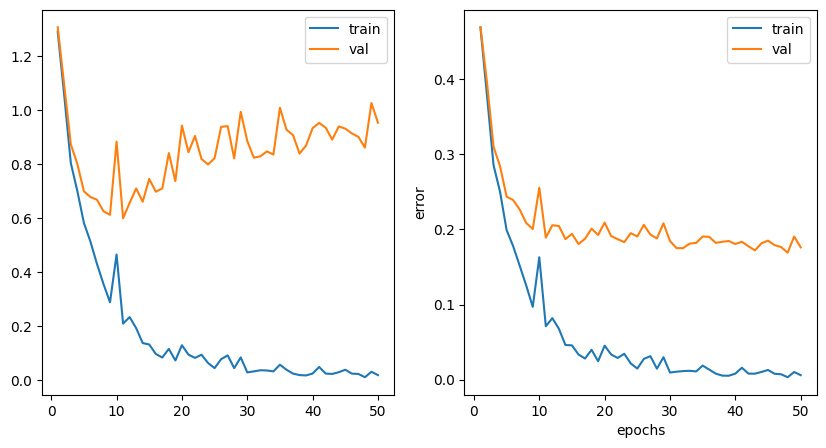

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, train_metric, val_metric, metric in zip(axes, [train_losses, train_errors], [val_losses, val_errors], ["loss", "error"]):
    epochs_range = np.arange(len(train_metric)) + 1

    sns.lineplot(ax=ax, x=epochs_range, y=train_metric, label="train")
    sns.lineplot(ax=ax, x=epochs_range, y=val_metric, label="val")

    plt.xlabel("epochs")
    plt.ylabel(metric)

In [38]:
model.load_state_dict(torch.load("best_weights", weights_only=True))

test_data_loader = DataLoader(CifarDataset(test_images, test_labels), batch_size, shuffle=False)

loss, accuracy = test(model, criterion, test_data_loader, device)
error = 1 - accuracy

print(f"\n{loss=}, {error=}")

Calculating loss & error: 100%|██████████| 250/250 [00:01<00:00, 134.07it/s]


loss=0.6006489893198014, error=0.19225000000000003
